In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pandas as pd
import time
import scipy

#Separate import for numpy and jax.numpy to have major felxibility
import jax.numpy as jnp
import numpy as np
from jax import jit,lax,random
from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions
from tensorflow_probability.substrates import jax as jtfp
jtfd = jtfp.distributions

np.random.seed(0)

/Users/leopere/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
sampled_perturbed = np.load('sampled_2D_two_clusters_near.npy')
data = sampled_perturbed[0 : 1000]
#DEFINING NUMBER OF CLUSTERS AND DIMENSION OF DATA
k = 10
d = 2
#Key to store for random generation
rng_key = random.PRNGKey(0)
cluster_allocs_recorded = []
uniq_vals_out = []
covs_recorded = []
mus_recorded = []

In [22]:
def run_one_gibbs(data, cluster_allocs, mus,covs, weights, alpha,bij,cov_prop_mu,cov_prop_cov):
    """
    Run one gibbs sampler iteration
    Takes in input values of the previous iteration and sample the new values from sample_uniq_vals_fullcond, update_weights and update_cluster_allocs
    Returns:   
    
    -cluster_allocs: for every data point, the cluster assigned
    -uniq_vals: array of parameters of the distributions. Matrix has d rows of the type:[mu[0], var[0,0], var[0,1]]
    -weights: array with the weights of the clusters 
     """
    
    n_clus = len(weights)
    
    for h in range(n_clus):
        
        #Extract data assigned to cluster h and sample 
        clusdata = data[cluster_allocs == h]
        if len(clusdata) != 0:
            mus[h],covs[h], acc_rate = sample_uniq_vals_fullcond_Wasserstein_NW_log(clusdata, mus,covs, h,bij,cov_prop_mu[h],cov_prop_cov)
        else:
            mus[h],covs[h], acc_rate = sample_uniq_vals_prior_Wasserstein_NW_log(mus,covs, h,bij,cov_prop_mu[h],cov_prop_cov)

    weights = update_weights(cluster_allocs ,n_clus, k, alpha)

    cluster_allocs = update_cluster_allocs(data, weights, mus,covs)
    
    #Save the values so that if we stop the kernel we have a visual output 
    global cluster_allocs_recorded
    cluster_allocs_recorded = cluster_allocs

    global mus_recorded
    mus_recorded = mus
    
    global covs_recorded
    covs_recorded = covs
    
    return cluster_allocs, mus,covs, weights, acc_rate

def run_mcmc(data, k , niter=1000, nburn=300, thin=5 ): 
    """
    Runs entire MCMC
    Takes in input data, number of clusters, number of iterations, burn-in and thin
    Returns the parameters recorded after burn-in phase
    """
    
    b = time.time() # only to measure time
    
    #Bijector setup
    tfb = tfp.bijectors
    bij = tfb.Chain([
            tfb.TransformDiagonal(tfb.Softplus()),
            tfb.FillTriangular()])

    #Starting Values
    cluster_allocs = tfd.Categorical(probs=np.ones(k) / k).sample(len(data))
    weights = np.ones(k)/k
    alpha = 0.1
    lam = 0.1
    mus = np.array(tfd.MultivariateNormalFullCovariance(np.mean(np.array(data), axis=0), np.eye(d) ).sample(k))
    covs = np.array(tfd.WishartTriL(df=d, scale_tril=tf.linalg.cholesky(np.eye(d)) ).sample(k))
    
    #Proposal Covariances
    cov_prop_cov = 0.02 * np.eye(3) #covariance matrix for the covariance sampling
    cov_prop_mu = 0.1 * np.eye(2)   #starting covariance matrix for the mean sampling
    
    #Adaptive Proposal
    t_adapt = nburn/10
    me=np.expand_dims(np.zeros(2),axis=0)
    mu_mean=np.repeat(me,k,axis=0) 
    co=np.expand_dims(cov_prop_mu,axis=0)
    cov_prop_mu =np.repeat(co, k,axis=0)
    
    #Output values
    allocs_out = []
    mus_out = []
    covs_out = []
    weights_out = []
    acc_rates = []
    
    #Useful value
    data_mean = np.mean(data, axis = 0)
    
    #Iterations
    for i in range(niter):
        
        cluster_allocs, mus,covs, weights, acc_rate = run_one_gibbs(
            data, cluster_allocs, mus,covs, weights, alpha,bij,cov_prop_mu,cov_prop_cov)
        acc_rates.append(acc_rate)
        
        #The covariance I adapt here is used in the following iteration(i+1). Since the update of mu_mean is done 
        #inside the function, we are actually passing to the function the mean from the 2 previous iteration(i-1)
        #and if we update it inside the function we obtain the mean from iteration i
        if(i>t_adapt):
            print("mu_mean" : + str(mu_mean))
            cov_prop_mu , mu_mean = update_proposal_covariance(cov_prop_mu,mu_mean,mus,i,k,d) 
            print(cov_prop_mu)
        else:
            mu_mean=(mu_mean*(i-1)+mus)/i
               
        
        
        if i > nburn and i % thin == 0:
            allocs_out.append(cluster_allocs)
            mus_out.append(mus.copy())
            covs_out.append(covs.copy())
            weights_out.append(weights)
            
        if i % 10 == 0 and i > 11:
            a = time.time()
            print("\rIter {0} / {1}".format(i+1, niter) + " Remaining minutes: " + str(round((a-b)*(niter-i)/(60*10) ,1)) , flush=False, end=" ")
            b = time.time()
            print("Acceptance rate: " + str(np.mean(acc_rates[-10:])))
            
    return allocs_out, mus_out,covs_out, weights_out,acc_rates

In [27]:
def g(x):
    """
    Function to modulate the Wasserstein Distance
    """
    #Shape parameters
    a = 5
    b = 0.5
    res = a*np.tanh( b * x )
    if(x < 5):
        return x
    else:
        return 5

def update_proposal_covariance(cov_prop_t,mu_mean_t_minus_one,mus,t,k,d): 
    sd= (2.4**2)/d
    eps=0.001
    temp=np.expand_dims(np.zeros(2),axis=0)
    mu_mean_t=np.repeat(temp,k,axis=0) 
    cov_prop_t_plus_one = cov_prop_t.copy()
    for h in range(k):
        
        mu_mean_t[h]=(mu_mean_t_minus_one[h]*(t-1)+mus[h])/t
        #a = (t-1)*cov_prop_t[h]/t
#         b = np.inner(mu_mean_t_minus_one[h],mu_mean_t_minus_one[h])
#         c = np.inner(mu_mean_t[h],mu_mean_t[h])
#         d = np.inner(mus[h],mus[h])
#         e = sd*(t*b - (t+1)*c + d + eps*np.eye(2))/t
        
    
    
        
        cov_prop_t_plus_one[h]= a + e
    

    return cov_prop_t_plus_one,mu_mean_t

def sample_uniq_vals_fullcond_Wasserstein_NW_log(clusdata, mus,covs, h,bij,cov_prop_mu,cov_prop_cov):
    """
    Perform one step of the Metropolis Hastings to sample a couple (mu,cov) from N*IW*Wasserstein
    """
    #Starting point of MH
    mu_old = mus[h]
    cov_old = covs[h]
    log_jac_cov_old = abs(bij.forward_log_det_jacobian( bij.inverse(cov_old) ) )
    
    # Sample the proposal using Bijector and compute jacobian term of transformation
    mu, cov, log_jac_cov = sample_from_bijector(mu_old, cov_prop_mu, cov_old, cov_prop_cov,bij)
    jac_term = log_jac_cov - log_jac_cov_old
    
    # Compute acceptance rate(and return it for tuning)
    beta = compute_beta_NW_log(clusdata,mus,covs, h, mu, cov,mu_old, cov_old,jac_term)
    beta = np.minimum(0, beta)
    accept_rate = np.exp(beta)
    
    draw = tfd.Uniform().sample()
    
    # Select the new or old values 
    if(np.log(draw) >= beta):
        return mu_old,cov_old,accept_rate

    else:
        return mu,cov,accept_rate
    
def sample_uniq_vals_prior_Wasserstein_NW_log(mus,covs, h,bij,cov_prop_mu,cov_prop_cov):
    """
    Perform one step of the Metropolis Hastings to sample a couple (mu,cov) from N*IW*Wasserstein
    """
    # Starting point of MH
    mu_old = mus[h]
    cov_old = covs[h]
    log_jac_cov_old = abs(bij.forward_log_det_jacobian( bij.inverse(cov_old) ) )
    
    # Sample the proposal using Bijector and compute jacobian term of transformation
    mu, cov, log_jac_cov = sample_from_bijector(mu_old, cov_prop_mu, cov_old, cov_prop_cov,bij)
    jac_term = log_jac_cov - log_jac_cov_old
    
    # Compute acceptance rate(and return it for tuning)
    beta = compute_beta_NW_prior_log(mus,covs, h, mu, cov,mu_old, cov_old,jac_term)
    beta = np.minimum(0, beta)
    accept_rate = np.exp(beta)
    
    draw = tfd.Uniform().sample()
    
    # Select the new or old values 
    if(np.log(draw) >= beta):
        return np.array(mu_old),np.array(cov_old),accept_rate

    else:
        return np.array(mu),np.array(cov),accept_rate
    

def sample_from_bijector(mu_old, cov_prop_mu, cov_old, cov_prop_cov, bijector):
    """
    Sample new mean and covariance matrix through the bijection
    """
    mu = tfd.MultivariateNormalFullCovariance(mu_old, cov_prop_mu).sample()
    
    chol = np.linalg.cholesky(cov_old)
    vec = bijector.inverse(chol)
    vec_sampl = tfd.MultivariateNormalFullCovariance(vec,cov_prop_cov).sample()
    cov_sampl = bijector.forward(vec_sampl)
    cov = np.matmul(cov_sampl , np.transpose(cov_sampl))
    log_jac = abs(bijector.forward_log_det_jacobian(vec_sampl))
    
    return mu,cov,log_jac

def compute_beta_NW_log(clusdata,mus,covs, h, mu, cov,mu_old, cov_old,jac_term):
    """
    Compute Metropolis Hastings term, knowing the proposal is symmetric
    The target is the Normal Inverse Wishart with parameters mu_n, lam_n, phi_n, nu_n
    """
        
    mu_0 = np.zeros(2)
    cov_0 = np.eye(2)
    nu_0 = 3
    phi_0 = np.eye(2)/nu_0
    
    # NW distribution terms
    num_0 = evaluate_NW_log(mu, cov, mu_0, cov_0, phi_0, nu_0)
    den_0 = evaluate_NW_log(mu_old, cov_old , mu_0, cov_0, phi_0, nu_0)
    
    # Data distribution terms
    num_1 = np.sum(tfd.MultivariateNormalFullCovariance(mu, cov).log_prob(clusdata))
    den_1 = np.sum(tfd.MultivariateNormalFullCovariance(mu_old, cov_old).log_prob(clusdata))
    
    # Wasserstein Distance terms
    sum_ = 0
    for j in range(k):
        if(j != h):
            mu_j = mus[j]
            cov_j = covs[j]
            sum_ = sum_ + np.log(compute_Wasserstein(mu , cov , mu_j , cov_j)) - np.log(compute_Wasserstein(mu_old , cov_old , mu_j, cov_j))

    return num_0 + num_1  - den_0 - den_1 + sum_ + jac_term

def compute_beta_NW_prior_log(mus,covs, h, mu, cov,mu_old, cov_old,jac_term):
    """
    Compute Metropolis Hastings term, knowing the proposal is symmetric
    The target is the Normal Inverse Wishart with parameters mu_n, lam_n, phi_n, nu_s the Normal Inverse Wishart with parameters mu_n, lam_n, phi_n, nus the Normal Inverse Wishart with parameters mu_n, lam_n, phi_n, nu_s the Normal Inverse Wishart with parameters mu_n, lam_n, phi_n, nu_"s the Normal Inverse Wishart with parameters mu_n, lam_n, phi_n, nu_s the Normal Inverse Wishart with parameters mu_n, lam_n, phi_n, nus the Normal Inverse Wishart with parameters mu_n, lam_n, phi_n, nu_s the Normal Inverse Wishart with parameters mu_n, lam_n, phi_n, nu_"n
    """
        
    mu_0 = np.zeros(2)
    cov_0 = np.eye(2)
    nu_0 = 3
    phi_0 = np.eye(2)/nu_0
    
    # NW distribution terms
    num = evaluate_NW_log(mu, cov, mu_0, cov_0, phi_0, nu_0)
    den = evaluate_NW_log(mu_old, cov_old , mu_0, cov_0, phi_0, nu_0)
    
    # Wasserstein Distance terms
    sum_ = 0
    for j in range(k):
        if(j != h):
            mu_j = mus[j]
            cov_j = covs[j]
            sum_ = sum_ + np.log(compute_Wasserstein(mu , cov , mu_j , cov_j)) - np.log(compute_Wasserstein(mu_old , cov_old , mu_j, cov_j))

    return num  - den + sum_ + jac_term
  
def evaluate_NW_log(x_mu, x_cov, mu_n, cov_n, phi_n, nu_n):
    """
    Evaluate the likelihood: L[ (x_mu, x_cov) | ( mu_n, cov_n, phi_n, nu_n ) ]
    L = Normal x Inverse Wishart
    """
    W = np.linalg.inv(phi_n)
    chol = np.linalg.cholesky(W) 
    inv_cov = np.linalg.inv(x_cov)

    f1 = tfd.WishartTriL(df=nu_n, scale_tril=chol).log_prob(inv_cov)
    f2 = tfd.MultivariateNormalFullCovariance(mu_n, cov_n).log_prob(x_mu)
    
    return f1 + f2

def compute_Wasserstein(mu_1, cov_1, mu_2, cov_2):
    """
    Wasserstein distance for the Gaussian Case, already taking consideration of g() to bound Wasserstein term
    """
    norm = np.linalg.norm(mu_1 - mu_2, ord = 2)
    sqrt_C2 = scipy.linalg.sqrtm(cov_2)
    C1_sqrt_C2 = np.matmul(cov_1,sqrt_C2)
    sqrt_C2_C1_sqrt_C2 = np.matmul(sqrt_C2,C1_sqrt_C2)
    trace = np.trace(cov_1 + cov_2 - 2 * scipy.linalg.sqrtm(sqrt_C2_C1_sqrt_C2))

    # Function g
    return g(norm+trace)

def update_weights(cluster_allocs, n_clus, k, alpha):

    n_by_clus = np.array([np.sum(cluster_allocs == h) for h in range(n_clus)])
    post_params = np.ones(k) * alpha + n_by_clus
    return tfd.Dirichlet(post_params.astype(float)).sample()

def update_cluster_allocs(data, weights, mus, covs):
    #print(weights)
    logprobs = tfd.MultivariateNormalFullCovariance(mus, covs).log_prob(data[:, np.newaxis])
    logprobs += np.log(weights)
    probs =  np.exp(logprobs)/(np.sum(np.exp(logprobs), axis=1))[:,None]
    return tfd.Categorical(probs=probs, validate_args=True).sample()

In [28]:
#RUNNING THE MCMC
start = time.time()
allocs_out, mus_out,covs_out, weights_out,accept_rate_out = run_mcmc(data, k , niter = 400,nburn = 200,thin = 1)
end = time.time()
print("Total time: " + str(end-start))

/Users/leopere/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: RuntimeWarning: divide by zero encountered in true_divide
/Users/leopere/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: RuntimeWarning: invalid value encountered in multiply


Iter 21 / 400 Remaining minutes: 18.5 Acceptance rate: 0.300012801006308
nan
nan
[[nan nan]
 [nan nan]]
nan
nan
[[nan nan]
 [nan nan]]
nan
nan
[[nan nan]
 [nan nan]]
nan
nan
[[nan nan]
 [nan nan]]
nan
nan
[[nan nan]
 [nan nan]]
nan
nan
[[nan nan]
 [nan nan]]
nan
nan
[[nan nan]
 [nan nan]]
nan
nan
[[nan nan]
 [nan nan]]
nan
nan
[[nan nan]
 [nan nan]]
nan
nan
[[nan nan]
 [nan nan]]
[[[nan nan]
  [nan nan]]

 [[nan nan]
  [nan nan]]

 [[nan nan]
  [nan nan]]

 [[nan nan]
  [nan nan]]

 [[nan nan]
  [nan nan]]

 [[nan nan]
  [nan nan]]

 [[nan nan]
  [nan nan]]

 [[nan nan]
  [nan nan]]

 [[nan nan]
  [nan nan]]

 [[nan nan]
  [nan nan]]]


ValueError: array must not contain infs or NaNs

# Traceplots

7    518
2    418
8     53
1     11
dtype: int64


<BarContainer object of 4 artists>

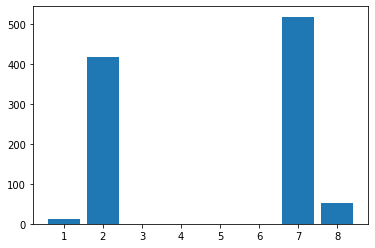

In [18]:
#View the number of points inside each cluster at the final iteration
print(pd.Series(cluster_allocs_recorded).value_counts())
x, y = np.unique(cluster_allocs_recorded, return_counts=True)
plt.bar(x, y)

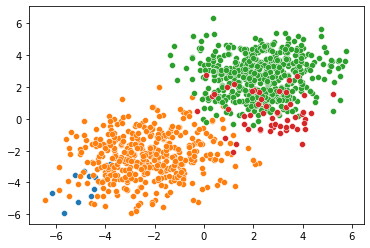

In [19]:
#scatterplot of clusters from last recorded iteration
for h in range(k):
    currd = data[cluster_allocs_recorded == h]
    sns.scatterplot(x=[elem[0] for elem in currd], y=[elem[1] for elem in currd])

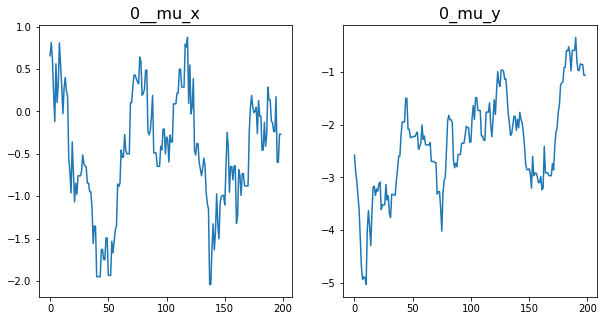

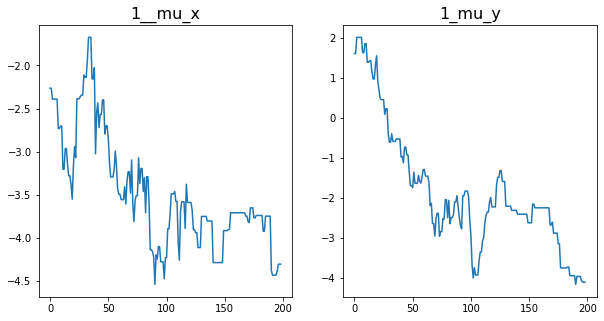

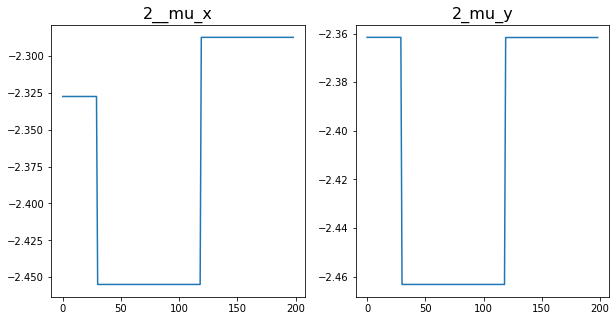

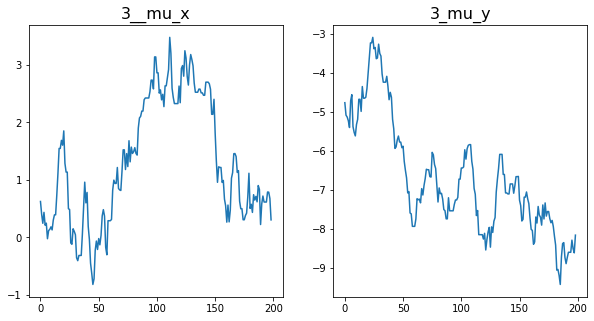

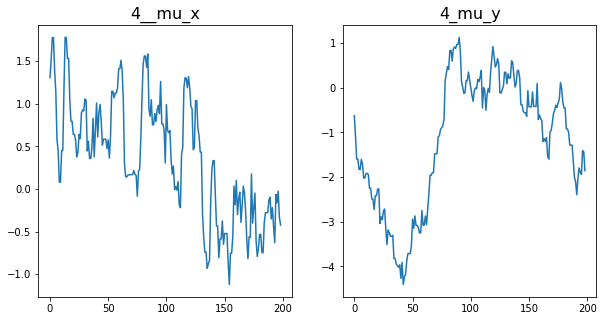

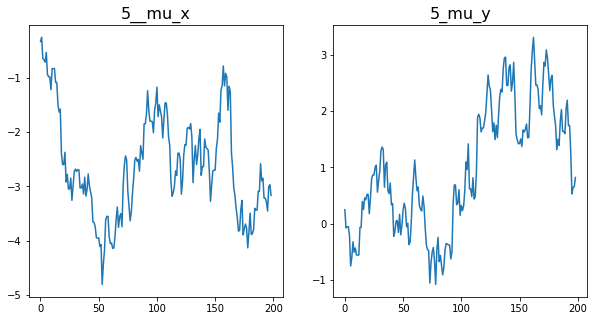

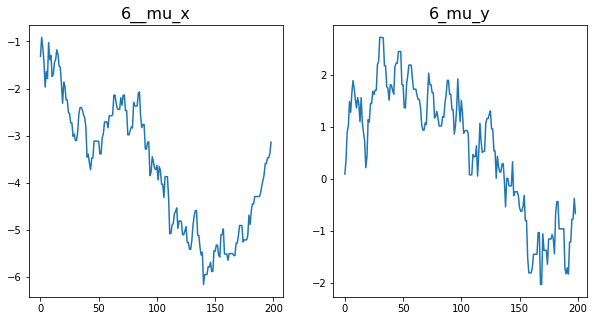

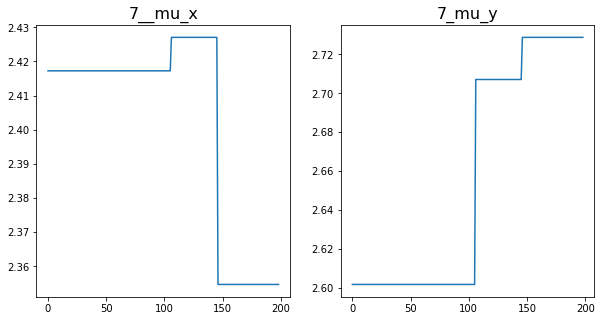

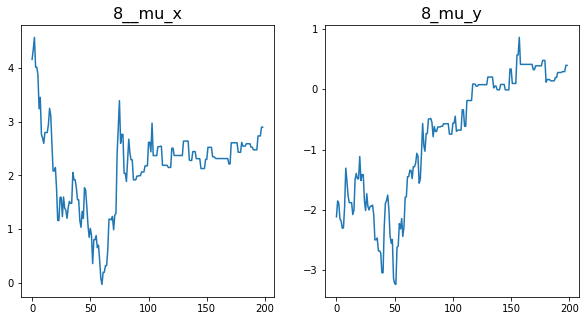

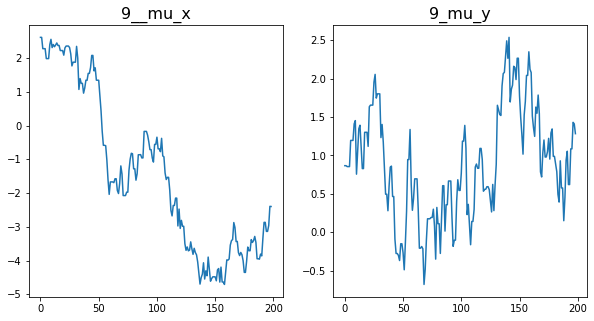

In [20]:
for i in range(k):
    
    #Get mean of the first gaussian component
    first_comp = [mu[i][0] for mu in mus_out]
    second_comp = [mu[i][1] for mu in mus_out]

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

    axes[0].plot(np.arange(len(first_comp)), first_comp)
    axes[0].set_title(str(i) + "__mu_x", fontsize=16)

    axes[1].plot(np.arange(len(second_comp)), second_comp,)
    axes[1].set_title(str(i) + "_mu_y", fontsize=16)

    plt.show()

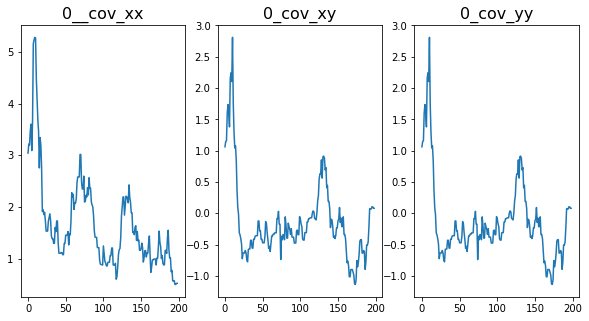

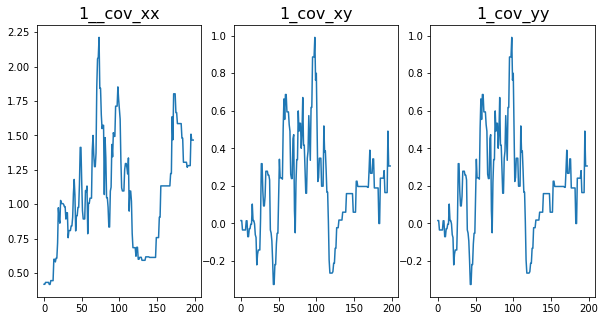

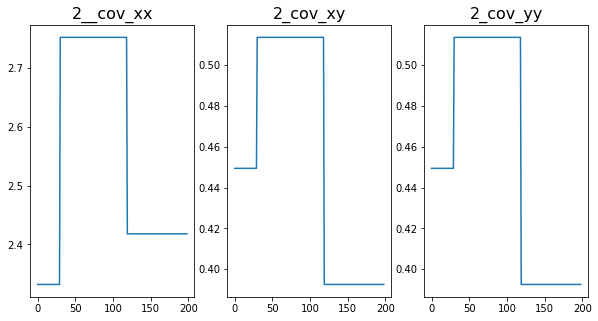

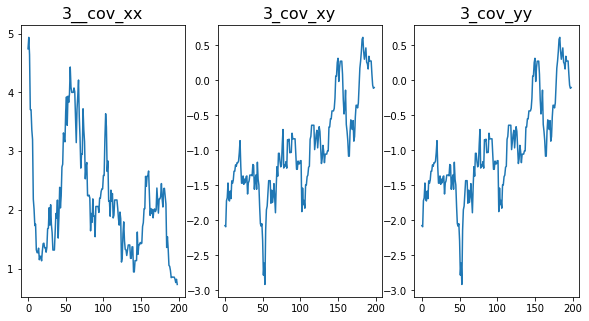

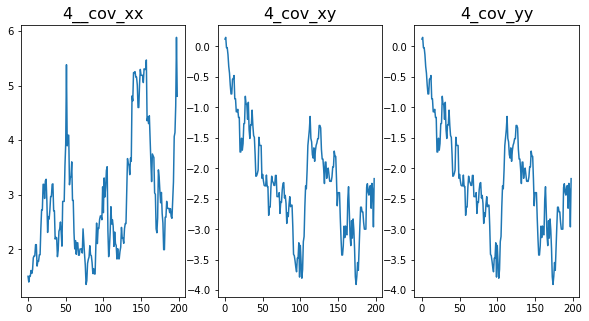

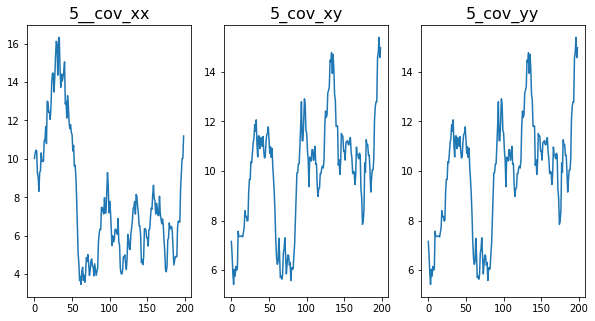

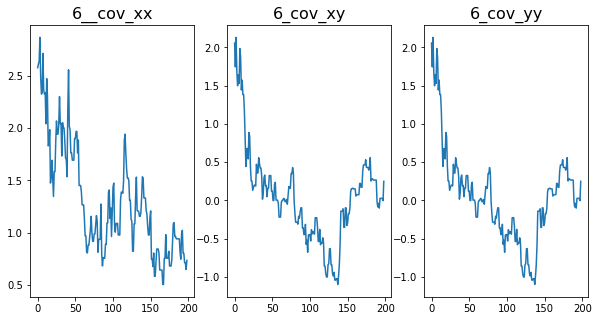

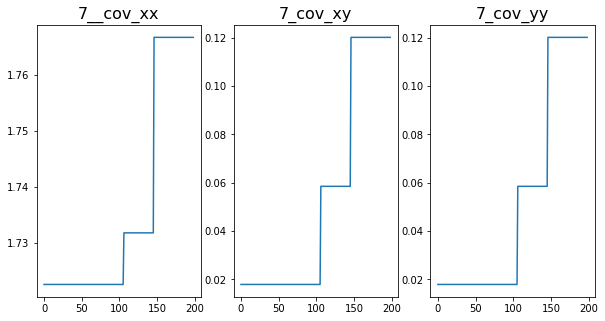

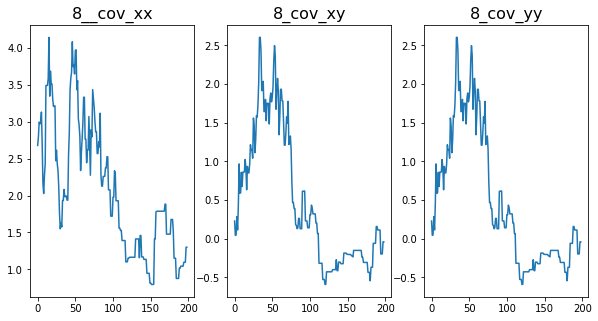

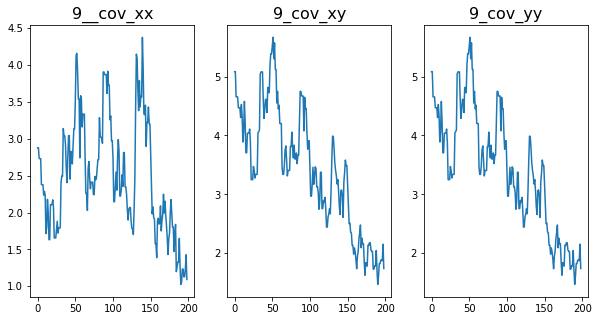

In [21]:
for i in range(k):
    
    #Get mean of the first gaussian component
    first_comp = [covs[i][0,0] for covs in covs_out]
    second_comp = [covs[i][0,1] for covs in covs_out]
    third_comp = [covs[i][1,1] for covs in covs_out]

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))

    axes[0].plot(np.arange(len(first_comp)), first_comp)
    axes[0].set_title(str(i) + "__cov_xx", fontsize=16)

    axes[1].plot(np.arange(len(second_comp)), second_comp,)
    axes[1].set_title(str(i) + "_cov_xy", fontsize=16)
    
    axes[2].plot(np.arange(len(third_comp)), second_comp,)
    axes[2].set_title(str(i) + "_cov_yy", fontsize=16)

    plt.show()

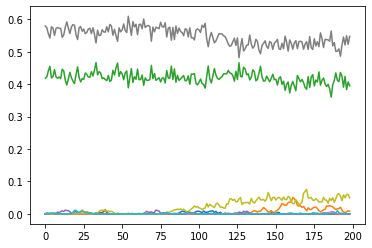

In [22]:
for i in range(k):
    weights = [w[i] for w in weights_out]
    plt.plot(np.arange(len(weights)) , weights)
    

# Check Metropolis Hastings Traceplots to fullconditional

In [ ]:
#Bijector setup
tfb = tfp.bijectors
bij = tfb.Chain([
        tfb.TransformDiagonal(tfb.Softplus()),
        tfb.FillTriangular()])
mus = np.array([ [0.5,0.5],[-0.5,-0.5] ])
covs = np.array([ np.eye(2) , np.eye(2)] )
cov_prop_mu = 0.05 * np.eye(2)
cov_prop_cov = 0.0001 * np.eye(3)
h = 0
mu_MH = []
cov_MH = []
y = np.array( [datum for datum in data if datum[0] > 0] )
for i in range(1500):
    mus[h],covs[h], acc_rate = sample_uniq_vals_fullcond_Wasserstein_NW_log(y,mus,covs, h,bij,cov_prop_mu,cov_prop_cov)
    print("Acc_rate : " + str(acc_rate))
    mu_MH.append(mus[h].copy())
    cov_MH.append(covs[h].copy())

In [ ]:

#Get mean of the first gaussian component
first_comp = [mu[0] for mu in mu_MH]
second_comp = [mu[1] for mu in mu_MH]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].plot(np.arange(len(first_comp)), first_comp)
axes[0].set_title("mu_x", fontsize=16)

axes[1].plot(np.arange(len(second_comp)), second_comp,)
axes[1].set_title("mu_y", fontsize=16)

plt.show()

In [ ]:
#Get mean of the first gaussian component
first_comp = [covs[0,0] for covs in cov_MH]
second_comp = [covs[0,1] for covs in cov_MH]
third_comp = [covs[1,1] for covs in cov_MH]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))

axes[0].plot(np.arange(len(first_comp)), first_comp)
axes[0].set_title("cov_xx", fontsize=16)

axes[1].plot(np.arange(len(second_comp)), second_comp,)
axes[1].set_title("cov_xy", fontsize=16)

axes[2].plot(np.arange(len(third_comp)), second_comp,)
axes[2].set_title("cov_yy", fontsize=16)

plt.show()

# Checking MH convergence to prior

In [ ]:
mus = np.array([ [0.5,0.5],[-0.5,-0.5] ])
covs = np.array([ np.eye(2) , np.eye(2)] )
cov_prop_mu = 0.5 * np.eye(2)
cov_prop_cov = 0.001 * np.eye(3)
h = 0
mu_MH = []
cov_MH = []
y = np.array( [datum for datum in data if datum[0] > 0] )
for i in range(1500):
    mus[h],covs[h], acc_rate = sample_uniq_vals_prior_Wasserstein_NW_log(mus,covs, h,bij,cov_prop_mu,cov_prop_cov)
    print("Acc_rate : " + str(acc_rate))
    mu_MH.append(mus[h].copy())
    cov_MH.append(covs[h].copy())

In [ ]:
#Get mean of the first gaussian component
first_comp = [mu[0] for mu in mu_MH]
second_comp = [mu[1] for mu in mu_MH]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].plot(np.arange(len(first_comp)), first_comp)
axes[0].set_title("mu_x", fontsize=16)

axes[1].plot(np.arange(len(second_comp)), second_comp,)
axes[1].set_title("mu_y", fontsize=16)

plt.show()

In [ ]:
#Get mean of the first gaussian component
first_comp = [covs[0,0] for covs in cov_MH]
second_comp = [covs[0,1] for covs in cov_MH]
third_comp = [covs[1,1] for covs in cov_MH]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))

axes[0].plot(np.arange(len(first_comp)), first_comp)
axes[0].set_title("cov_xx", fontsize=16)

axes[1].plot(np.arange(len(second_comp)), second_comp,)
axes[1].set_title("cov_xy", fontsize=16)

axes[2].plot(np.arange(len(third_comp)), second_comp,)
axes[2].set_title("cov_yy", fontsize=16)

plt.show()